In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from scipy import stats

mpl.rc('font', family='Malgun Gothic')

path = "../../"

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
df = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+'test.csv')

In [5]:
pd.set_option("display.max_columns", 30)

In [6]:
df

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,TRAIN_000000,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,10.0,38600,220.0,CHMT36,"China, People's Republic Of",0.14,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,TRAIN_000001,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,10.0,28100,220.0,CUFV52,Singapore,-3.16,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,TRAIN_000002,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,10.0,96400,300.0,ISIG88,Liberia,0.00,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,TRAIN_000003,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,0.0,700,70.0,MWFU27,Nauru,4.34,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,TRAIN_000004,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,10.0,19300,180.0,OXZY41,Panama,1.92,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,TRAIN_367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23,J661243,40.0,13,93200,20.0,10.0,51300,230.0,DQYE27,Liberia,NaN,NaN,NaN,NaN,6,61.25,62.21,55.70,1333.609109,0.000360,65.850000
367437,TRAIN_367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,10.0,9,1280,0.0,0.0,500,60.0,PBOG62,Japan,-0.06,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,TRAIN_367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,Q635545,30.0,6,25000,20.0,10.0,25100,180.0,JOZU66,Cyprus,-0.63,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,TRAIN_367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,10.0,8,2400,10.0,0.0,750,80.0,UDKN12,Japan,3.74,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


In [7]:
def get_gm(y):
    temp = np.mean(np.log(y))
    return np.exp(temp)

def box_cox_transformation(y, lambda1, lambda2=0):
    y = y+lambda2
    gm = get_gm(y)
    if lambda1 != 0:
        bc_tr = (y**(lambda1)-1)/(lambda1*(gm**(lambda1-1)))
    else:
        bc_tr = gm(np.log(y))
    return bc_tr

In [8]:
from scipy import stats

gt_lambda, lambda_optimal = stats.boxcox(df['BDI_ADJ'])
print(lambda_optimal)

0.04539837082878007


In [9]:
lambda_bdi = lambda_optimal

In [10]:
df['BDI_ADJ'] = box_cox_transformation(df['BDI_ADJ'], lambda_bdi)

<Axes: xlabel='BDI_ADJ', ylabel='Count'>

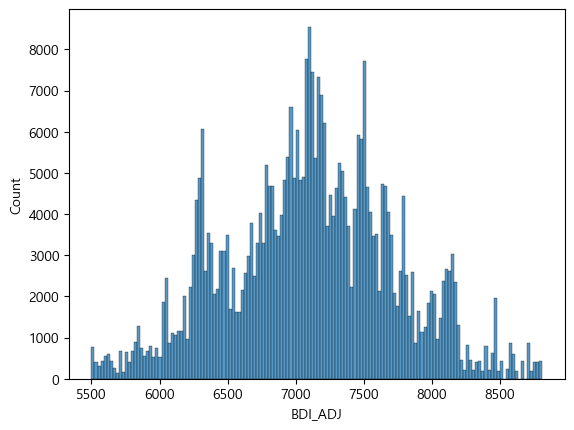

In [11]:
sns.histplot(df['BDI_ADJ'])

In [12]:
df.drop(columns = ['SHIPMANAGER'], inplace=True)

test.drop(columns = ['SHIPMANAGER'], inplace=True)

In [13]:
df['CI_HOUR'] = np.log1p(df['CI_HOUR'])

In [14]:
df.loc[df['DIST']==0, 'd_zero'] = 1
df.loc[df['DIST']!=0, 'd_zero'] = 0

df.drop(columns = ['BREADTH', "GT", "BRENT"], inplace=True)
test.drop(columns=['BREADTH', "GT", 'BRENT',], inplace=True)

In [15]:
df

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,d_zero
0,TRAIN_000000,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,10.0,38600,220.0,"China, People's Republic Of",0.14,3.77,15.9,2.730798,12,42.01,43.16,40.96,7317.810541,0.001660,1.398305,0.0
1,TRAIN_000001,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,10.0,28100,220.0,Singapore,-3.16,-6.72,24.5,4.289058,10,67.53,64.55,59.34,7789.674632,0.001614,2.898043,0.0
2,TRAIN_000002,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,10.0,96400,300.0,Liberia,0.00,0.00,9.4,0.000000,14,65.30,66.39,56.94,6332.984204,0.001743,4.603444,0.0
3,TRAIN_000003,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,0.0,700,70.0,Nauru,4.34,-7.31,22.1,4.693735,7,43.02,43.15,41.11,7099.511270,0.000069,0.000000,1.0
4,TRAIN_000004,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,10.0,19300,180.0,Panama,1.92,2.31,22.8,2.345875,14,90.45,93.65,88.11,7035.720240,0.000197,4.575026,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,TRAIN_367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23,J661243,40.0,13,93200,20.0,10.0,51300,230.0,Liberia,NaN,NaN,NaN,NaN,6,61.25,62.21,55.70,7253.866382,0.000360,4.202451,0.0
367437,TRAIN_367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,10.0,9,1280,0.0,0.0,500,60.0,Japan,-0.06,0.87,17.1,1.028558,11,105.37,109.34,104.69,7709.878207,0.000552,0.000000,1.0
367438,TRAIN_367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,Q635545,30.0,6,25000,20.0,10.0,25100,180.0,Cyprus,-0.63,3.36,31.7,2.557156,15,97.73,99.10,95.78,7470.924009,0.002615,0.691896,0.0
367439,TRAIN_367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,10.0,8,2400,10.0,0.0,750,80.0,Japan,3.74,-2.44,10.8,3.055715,19,49.75,50.08,47.02,7120.912887,0.000069,0.000000,1.0


C:\Users\dohyeong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='DIST', ylabel='Count'>

C:\Users\dohyeong\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\dohyeong\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


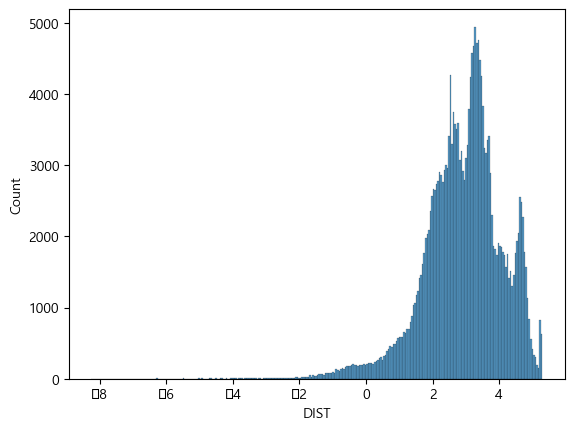

In [16]:
sns.histplot(np.log(df['DIST']))

C:\Users\dohyeong\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\dohyeong\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


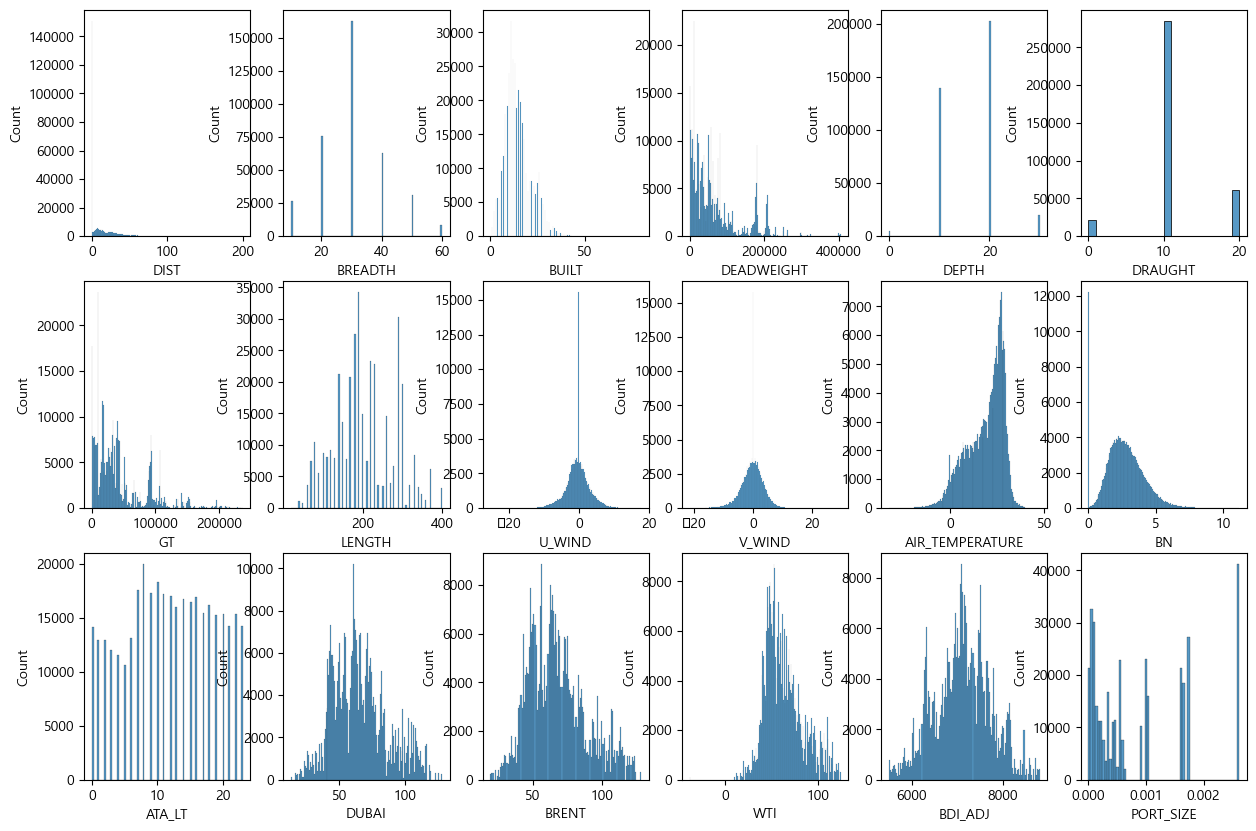

In [17]:
cols = ['DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE']

fig, ax = plt.subplots(3, 6)
fig.set_size_inches((15, 10))
dflist = cols
colors = ['black', 'blue', 'red', 'green']
k = 0
for i in range(0, 3):
    for j in range(0, 6):
        sns.histplot(df[dflist[k]], ax=ax[i, j])
        k += 1

In [18]:
df['DIST'] = np.log1p(df['DIST'])

test['DIST'] = np.log1p(test['DIST'])

In [19]:
target_df = df['CI_HOUR']
df.drop(columns = 'CI_HOUR', inplace=True)


In [20]:
cols = ['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']

In [21]:
mms = MinMaxScaler()

In [22]:
mms.fit(df[['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']])

MinMaxScaler()

In [23]:
scaled = mms.transform(df[['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']])

In [24]:
scaled = pd.DataFrame(scaled)

In [25]:
scaled.columns = ['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']

In [26]:
scaled

,BREADTH,DEPTH,DRAUGHT,LENGTH
0,0.4,0.666667,0.5,0.526316
1,0.4,0.666667,0.5,0.526316
2,0.8,0.666667,0.5,0.736842
3,0.0,0.333333,0.0,0.131579
4,0.4,0.333333,0.5,0.421053
...,...,...,...,...
367436,0.6,0.666667,0.5,0.552632
367437,0.0,0.000000,0.0,0.105263
367438,0.4,0.666667,0.5,0.421053
367439,0.0,0.333333,0.0,0.157895


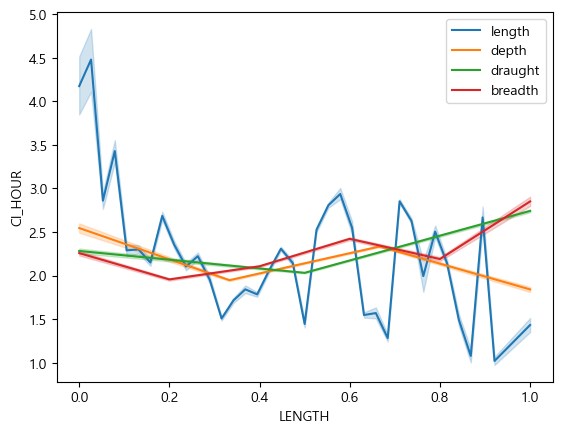

In [27]:
sns.lineplot(x = scaled['LENGTH'], y=target_df, label='length')
sns.lineplot(x= scaled['DEPTH'], y=target_df, label='depth')
sns.lineplot(x = scaled['DRAUGHT'], y=target_df, label='draught')
sns.lineplot(x = scaled['BREADTH'], y=target_df, label='breadth')
plt.legend()

In [28]:
cols = ['LENGTH', 'DEPTH', 'DRAUGHT', 'BREADTH']

In [29]:
for i in cols:
    df[i] = scaled[i]

In [30]:
df

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,d_zero
0,TRAIN_000000,CN,EKP8,Bulk,3.457470,2020-10-15 4:03,Z517571,0.4,28,73100,0.666667,0.5,38600,0.526316,"China, People's Republic Of",0.14,3.77,15.9,2.730798,12,42.01,43.16,40.96,7317.810541,0.001660,0.0
1,TRAIN_000001,CN,EUC8,Container,4.162321,2019-09-17 2:55,U467618,0.4,15,37900,0.666667,0.5,28100,0.526316,Singapore,-3.16,-6.72,24.5,4.289058,10,67.53,64.55,59.34,7789.674632,0.001614,0.0
2,TRAIN_000002,CN,NGG6,Container,4.515545,2019-02-23 6:43,V378315,0.8,7,115000,0.666667,0.5,96400,0.736842,Liberia,0.00,0.00,9.4,0.000000,14,65.30,66.39,56.94,6332.984204,0.001743,0.0
3,TRAIN_000003,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,0.0,33,1490,0.333333,0.0,700,0.131579,Nauru,4.34,-7.31,22.1,4.693735,7,43.02,43.15,41.11,7099.511270,0.000069,1.0
4,TRAIN_000004,RU,NNC2,Container,2.283782,2022-08-13 12:57,D215135,0.4,10,27600,0.333333,0.5,19300,0.421053,Panama,1.92,2.31,22.8,2.345875,14,90.45,93.65,88.11,7035.720240,0.000197,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,TRAIN_367436,CN,YRT6,Bulk,4.094648,2017-11-11 22:23,J661243,0.6,13,93200,0.666667,0.5,51300,0.552632,Liberia,NaN,NaN,NaN,NaN,6,61.25,62.21,55.70,7253.866382,0.000360,0.0
367437,TRAIN_367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,0.0,9,1280,0.000000,0.0,500,0.105263,Japan,-0.06,0.87,17.1,1.028558,11,105.37,109.34,104.69,7709.878207,0.000552,1.0
367438,TRAIN_367438,SG,GIW5,Container,1.018353,2022-07-14 7:58,Q635545,0.4,6,25000,0.666667,0.5,25100,0.421053,Cyprus,-0.63,3.36,31.7,2.557156,15,97.73,99.10,95.78,7470.924009,0.002615,0.0
367439,TRAIN_367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,0.0,8,2400,0.333333,0.0,750,0.157895,Japan,3.74,-2.44,10.8,3.055715,19,49.75,50.08,47.02,7120.912887,0.000069,1.0


In [31]:
ata = pd.to_datetime(df['ATA'])

ata = pd.DataFrame(ata)

ata['year'] = ata['ATA'].dt.year
ata['month'] = ata['ATA'].dt.month

ata['dmonth'] = (ata['year']-2014)*12 + ata['month']

ata['dayofweek'] = ata['ATA'].dt.dayofweek

ata

,ATA,year,month,dmonth,dayofweek
0,2020-10-15 04:03:00,2020,10,82,3
1,2019-09-17 02:55:00,2019,9,69,1
2,2019-02-23 06:43:00,2019,2,62,5
3,2020-09-18 22:06:00,2020,9,81,4
4,2022-08-13 12:57:00,2022,8,104,5
...,...,...,...,...,...
367436,2017-11-11 22:23:00,2017,11,47,5
367437,2022-04-29 02:58:00,2022,4,100,4
367438,2022-07-14 07:58:00,2022,7,103,3
367439,2020-12-22 10:07:00,2020,12,84,1


In [32]:
df = pd.concat([df, ata['year'], ata['month'], ata['dmonth'], ata['dayofweek']], axis=1)

In [33]:
df

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,d_zero,year,month,dmonth,dayofweek
0,TRAIN_000000,CN,EKP8,Bulk,3.457470,2020-10-15 4:03,Z517571,0.4,28,73100,0.666667,0.5,38600,0.526316,"China, People's Republic Of",0.14,3.77,15.9,2.730798,12,42.01,43.16,40.96,7317.810541,0.001660,0.0,2020,10,82,3
1,TRAIN_000001,CN,EUC8,Container,4.162321,2019-09-17 2:55,U467618,0.4,15,37900,0.666667,0.5,28100,0.526316,Singapore,-3.16,-6.72,24.5,4.289058,10,67.53,64.55,59.34,7789.674632,0.001614,0.0,2019,9,69,1
2,TRAIN_000002,CN,NGG6,Container,4.515545,2019-02-23 6:43,V378315,0.8,7,115000,0.666667,0.5,96400,0.736842,Liberia,0.00,0.00,9.4,0.000000,14,65.30,66.39,56.94,6332.984204,0.001743,0.0,2019,2,62,5
3,TRAIN_000003,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,0.0,33,1490,0.333333,0.0,700,0.131579,Nauru,4.34,-7.31,22.1,4.693735,7,43.02,43.15,41.11,7099.511270,0.000069,1.0,2020,9,81,4
4,TRAIN_000004,RU,NNC2,Container,2.283782,2022-08-13 12:57,D215135,0.4,10,27600,0.333333,0.5,19300,0.421053,Panama,1.92,2.31,22.8,2.345875,14,90.45,93.65,88.11,7035.720240,0.000197,0.0,2022,8,104,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,TRAIN_367436,CN,YRT6,Bulk,4.094648,2017-11-11 22:23,J661243,0.6,13,93200,0.666667,0.5,51300,0.552632,Liberia,NaN,NaN,NaN,NaN,6,61.25,62.21,55.70,7253.866382,0.000360,0.0,2017,11,47,5
367437,TRAIN_367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,0.0,9,1280,0.000000,0.0,500,0.105263,Japan,-0.06,0.87,17.1,1.028558,11,105.37,109.34,104.69,7709.878207,0.000552,1.0,2022,4,100,4
367438,TRAIN_367438,SG,GIW5,Container,1.018353,2022-07-14 7:58,Q635545,0.4,6,25000,0.666667,0.5,25100,0.421053,Cyprus,-0.63,3.36,31.7,2.557156,15,97.73,99.10,95.78,7470.924009,0.002615,0.0,2022,7,103,3
367439,TRAIN_367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,0.0,8,2400,0.333333,0.0,750,0.157895,Japan,3.74,-2.44,10.8,3.055715,19,49.75,50.08,47.02,7120.912887,0.000069,1.0,2020,12,84,1


In [34]:
ohe = OneHotEncoder(handle_unknown='ignore', min_frequency=15, sparse=False, drop='first',)

In [35]:
ohe.fit(df[['ARI_PO', 'ARI_CO', 'SHIP_TYPE_CATEGORY', 'FLAG']])

C:\Users\dohyeong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=15,
              sparse=False, sparse_output=False)

In [36]:
encoded = ohe.transform(df[['ARI_PO', 'ARI_CO', 'SHIP_TYPE_CATEGORY', 'FLAG']])

In [37]:
encoded = pd.DataFrame(encoded, columns = ohe.get_feature_names_out())

In [38]:
encoded

,ARI_PO_AZU6,ARI_PO_BAZ5,ARI_PO_BGD2,ARI_PO_BGX4,ARI_PO_CEI5,ARI_PO_CSP6,ARI_PO_CXL1,ARI_PO_DEJ2,ARI_PO_DMD4,ARI_PO_EFG4,ARI_PO_EIA2,ARI_PO_EKP8,ARI_PO_EUC8,ARI_PO_EVL6,ARI_PO_EVX2,...,FLAG_Switzerland,FLAG_Syria,FLAG_Tanzania (Zanzibar),FLAG_Thailand,FLAG_Togo,FLAG_Turkey,FLAG_Tuvalu,FLAG_Ukraine,FLAG_United Arab Emirates,FLAG_United Kingdom,FLAG_United States Of America,FLAG_Unknown,FLAG_Vanuatu,FLAG_Vietnam,FLAG_infrequent_sklearn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df= pd.concat([df, encoded], axis=1)

In [40]:
df

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,FLAG,...,FLAG_Switzerland,FLAG_Syria,FLAG_Tanzania (Zanzibar),FLAG_Thailand,FLAG_Togo,FLAG_Turkey,FLAG_Tuvalu,FLAG_Ukraine,FLAG_United Arab Emirates,FLAG_United Kingdom,FLAG_United States Of America,FLAG_Unknown,FLAG_Vanuatu,FLAG_Vietnam,FLAG_infrequent_sklearn
0,TRAIN_000000,CN,EKP8,Bulk,3.457470,2020-10-15 4:03,Z517571,0.4,28,73100,0.666667,0.5,38600,0.526316,"China, People's Republic Of",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAIN_000001,CN,EUC8,Container,4.162321,2019-09-17 2:55,U467618,0.4,15,37900,0.666667,0.5,28100,0.526316,Singapore,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRAIN_000002,CN,NGG6,Container,4.515545,2019-02-23 6:43,V378315,0.8,7,115000,0.666667,0.5,96400,0.736842,Liberia,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAIN_000003,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,0.0,33,1490,0.333333,0.0,700,0.131579,Nauru,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAIN_000004,RU,NNC2,Container,2.283782,2022-08-13 12:57,D215135,0.4,10,27600,0.333333,0.5,19300,0.421053,Panama,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,TRAIN_367436,CN,YRT6,Bulk,4.094648,2017-11-11 22:23,J661243,0.6,13,93200,0.666667,0.5,51300,0.552632,Liberia,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367437,TRAIN_367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,0.0,9,1280,0.000000,0.0,500,0.105263,Japan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367438,TRAIN_367438,SG,GIW5,Container,1.018353,2022-07-14 7:58,Q635545,0.4,6,25000,0.666667,0.5,25100,0.421053,Cyprus,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367439,TRAIN_367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,0.0,8,2400,0.333333,0.0,750,0.157895,Japan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df.drop(columns = ['ARI_PO', 'ARI_CO', 'SHIP_TYPE_CATEGORY', 'FLAG', 'ID', 'ATA'], inplace=True)

In [42]:
df

,SAMPLE_ID,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,...,FLAG_Switzerland,FLAG_Syria,FLAG_Tanzania (Zanzibar),FLAG_Thailand,FLAG_Togo,FLAG_Turkey,FLAG_Tuvalu,FLAG_Ukraine,FLAG_United Arab Emirates,FLAG_United Kingdom,FLAG_United States Of America,FLAG_Unknown,FLAG_Vanuatu,FLAG_Vietnam,FLAG_infrequent_sklearn
0,TRAIN_000000,3.457470,0.4,28,73100,0.666667,0.5,38600,0.526316,0.14,3.77,15.9,2.730798,12,42.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAIN_000001,4.162321,0.4,15,37900,0.666667,0.5,28100,0.526316,-3.16,-6.72,24.5,4.289058,10,67.53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRAIN_000002,4.515545,0.8,7,115000,0.666667,0.5,96400,0.736842,0.00,0.00,9.4,0.000000,14,65.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAIN_000003,0.000000,0.0,33,1490,0.333333,0.0,700,0.131579,4.34,-7.31,22.1,4.693735,7,43.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAIN_000004,2.283782,0.4,10,27600,0.333333,0.5,19300,0.421053,1.92,2.31,22.8,2.345875,14,90.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,TRAIN_367436,4.094648,0.6,13,93200,0.666667,0.5,51300,0.552632,NaN,NaN,NaN,NaN,6,61.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367437,TRAIN_367437,0.000000,0.0,9,1280,0.000000,0.0,500,0.105263,-0.06,0.87,17.1,1.028558,11,105.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367438,TRAIN_367438,1.018353,0.4,6,25000,0.666667,0.5,25100,0.421053,-0.63,3.36,31.7,2.557156,15,97.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367439,TRAIN_367439,0.000000,0.0,8,2400,0.333333,0.0,750,0.157895,3.74,-2.44,10.8,3.055715,19,49.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df.to_csv("dataframe.csv")

In [44]:
ohe = OneHotEncoder(handle_unknown='ignore', min_frequency=15, sparse=False, drop='first')

In [45]:
categories = ohe.fit_transform(df[['SHIP_TYPE_CATEGORY']])

KeyError: "None of [Index(['SHIP_TYPE_CATEGORY'], dtype='object')] are in the [columns]"

In [ ]:
categories = pd.DataFrame(categories, columns=ohe.get_feature_names_out())

In [ ]:
df = pd.concat([df, categories], axis=1)

In [ ]:
df.drop(columns = ['SHIP_TYPE_CATEGORY', 'SAMPLE_ID'], inplace=True)

In [ ]:
df

In [ ]:
df.drop(columns = ['ARI_PO', 'FLAG', 'BRENT', 'ID', ], inplace=True)
test.drop(columns = ['ARI_PO', 'FLAG', 'BRENT', 'ID'], inplace=True)

In [ ]:
df.drop(columns = 'ATA', inplace=True)

In [ ]:
df.to_csv('dataframe2.csv')
test.to_csv("test2.csv")

In [ ]:
df.drop()

In [ ]:
df.drop(columns = 'ARI_CO', inplace=True)
test.drop(columns = 'ARI_CO', inplace=True)

In [ ]:
df

In [ ]:
df = pd.concat([df, target_df], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df1 = df[df['AIR_TEMPERATURE'].isnull()]
df2 = df[df['AIR_TEMPERATURE'].notnull()]

In [ ]:
target1 = df1['CI_HOUR']
df1.drop(columns = 'CI_HOUR', inplace=True)

target2 = df2['CI_HOUR']
df2.drop(columns = 'CI_HOUR', inplace=True)

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(df1, target1, test_size=0.2)

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(df2, target2, test_size=0.2)

In [ ]:
x_train1.drop(columns = ['U_WIND', 'V_WIND', "AIR_TEMPERATURE", 'BN'], inplace=True)
x_test1.drop(columns = ['U_WIND', "V_WIND", 'AIR_TEMPERATURE', 'BN'], inplace=True)

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lr1 = LGBMRegressor()
lr2 = LGBMRegressor()

In [ ]:
lr1.fit(x_train1, y_train1)

In [ ]:
pred1 = lr1.predict(x_test1)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mae = mean_absolute_error

In [ ]:
print(mae(pred1, y_test1))

In [ ]:
lr2.fit(x_train2, y_train2)
pred2 = lr2.predict(x_test2)
print(mae(pred2, y_test2))

In [ ]:
test

In [ ]:
test_id = test['SAMPLE_ID']
test.drop(columns = ['SAMPLE_ID'], inplace=True)

In [ ]:
test.loc[test['DIST']==0, 'd_zero'] = 1
test.loc[test['DIST']!=0, 'd_zero'] = 0

In [ ]:
ata = pd.to_datetime(test['ATA'])

ata = pd.DataFrame(ata)

ata['year'] = ata['ATA'].dt.year
ata['month'] = ata['ATA'].dt.month

ata['dmonth'] = (ata['year']-2014)*12 + ata['month']

ata['dayofweek'] = ata['ATA'].dt.dayofweek

ata

In [ ]:
test = pd.concat([test, ata['year'], ata['month'], ata['dmonth'], ata['dayofweek']], axis=1)

In [ ]:
encoded_test = mms.transform(test[['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']])

In [ ]:
encoded_test = pd.DataFrame(encoded_test, columns = ['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH'])

In [ ]:
encoded_test

In [ ]:
for i in ['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']:
    test[i] = encoded_test[i]

In [ ]:
test

In [ ]:
test_ships = ohe.transform(test[['SHIP_TYPE_CATEGORY']])

In [ ]:
test_ships = pd.DataFrame(test_ships, columns=ohe.get_feature_names_out())

In [ ]:
test = pd.concat([test, test_ships], axis=1)

In [ ]:
set(test.columns)-set(df.columns)

In [ ]:
test.drop(columns = ['SHIP_TYPE_CATEGORY', 'ATA'], inplace=True)

In [ ]:
test1 = test[test['AIR_TEMPERATURE'].isnull()]
test2 = test[test['AIR_TEMPERATURE'].notnull()]

In [ ]:
test1.drop(columns = ['U_WIND', "V_WIND", "AIR_TEMPERATURE", "BN"], inplace=True)

In [ ]:
test1pred = lr1.predict(test1)
test2pred = lr2.predict(test2)

In [ ]:
test1

In [ ]:
test1pred = pd.DataFrame(test1pred)

In [ ]:
test2pred = pd.DataFrame(test2pred)

In [ ]:
test1index = pd.DataFrame(test1.index)

In [ ]:
test1pred = pd.concat([test1index, test1pred], axis=1)

In [ ]:
test1pred.columns = ['SAMPLE_ID', "CI_HOUR"]

In [ ]:
test2index = pd.DataFrame(test2.index)
test2pred = pd.concat([test2index, test2pred], axis=1)

In [ ]:
test2pred.columns = ['SAMPLE_ID', 'CI_HOUR']

In [ ]:
test1pred

In [ ]:
testpred = pd.concat([test1pred, test2pred], axis=0)

In [ ]:
testpred = testpred.sort_values('SAMPLE_ID')

In [ ]:
test_id

In [ ]:
testpred = testpred.reset_index()

In [ ]:
testpred.drop(columns = ['index', 'SAMPLE_ID'], inplace=True)

In [ ]:
testpred

In [ ]:
test_id = pd.DataFrame(test_id)

In [ ]:
test_id

In [ ]:
testpred = pd.concat([test_id, testpred], axis=1)

In [ ]:
testpred = testpred.set_index('SAMPLE_ID')

In [ ]:
testpred.to_csv("predicted1.csv")

In [ ]:
testpred

In [ ]:
import xgboost
from xgboost import XGBRegressor

In [ ]:
xgbr1 = XGBRegressor()
xgbr2 = XGBRegressor()

In [ ]:
xgbr1.fit(x_train1, y_train1)
xgbr2.fit(x_train2, y_train2)

In [ ]:
xgbpred1 = xgbr.predict(x_test1)

In [ ]:
print(mae(xgbpred1, y_test1))

In [ ]:
predxgb1 = xgbr1.predict(test1)
predxgb2 = xgbr2.predict(test2)

In [ ]:
predxgb1 = pd.DataFrame(predxgb1)

In [ ]:
predxgb1

In [ ]:
predxgb2 = pd.DataFrame(predxgb2)

In [ ]:
test1index = pd.DataFrame(test1.index)
test2index = pd.DataFrame(test2.index)

In [ ]:
predxgb1 = pd.concat([test1index, predxgb1], axis=1)
predxgb2 = pd.concat([test2index, predxgb2], axis=1)

In [ ]:
predxgb1.columns = ['SAMPLE_ID', "CI_HOUR"]
predxgb2.columns = ['SAMPLE_ID', 'CI_HOUR']

In [ ]:
predxgb = pd.concat([predxgb1, predxgb2], axis=0)

In [ ]:
predxgb.sort_values('SAMPLE_ID')

In [ ]:
predxgb = predxgb.sort_values('SAMPLE_ID')

In [ ]:
predxgb = predxgb.set_index('SAMPLE_ID')

In [ ]:
predxgb = pd.concat([test_id, predxgb], axis=1)

In [ ]:
predxgb= predxgb.set_index('SAMPLE_ID')

In [ ]:
predxgb.to_csv("predxgb.csv")

In [ ]:
predxgb

In [ ]:
predxgb